## Model Training

#### 1.1 Import Data and Required Packages
##### Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [1]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

#### Import the CSV Data as Pandas DataFrame

In [2]:
df = pd.read_csv('data/stud.csv')

#### Show Top 5 Records

In [3]:
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


#### Preparing X and Y variables

In [4]:
X = df.drop(columns=['math_score'],axis=1)

In [5]:
X.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75


In [6]:
print("Categories in 'gender' variable:     ",end=" " )
print(df['gender'].unique())

print("Categories in 'race_ethnicity' variable:  ",end=" ")
print(df['race_ethnicity'].unique())

print("Categories in'parental level of education' variable:",end=" " )
print(df['parental_level_of_education'].unique())

print("Categories in 'lunch' variable:     ",end=" " )
print(df['lunch'].unique())

print("Categories in 'test preparation course' variable:     ",end=" " )
print(df['test_preparation_course'].unique())

Categories in 'gender' variable:      ['female' 'male']
Categories in 'race_ethnicity' variable:   ['group B' 'group C' 'group A' 'group D' 'group E']
Categories in'parental level of education' variable: ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Categories in 'lunch' variable:      ['standard' 'free/reduced']
Categories in 'test preparation course' variable:      ['none' 'completed']


In [7]:
y = df['math_score']

In [8]:
y

0      72
1      69
2      90
3      47
4      76
       ..
995    88
996    62
997    59
998    68
999    77
Name: math_score, Length: 1000, dtype: int64

In [9]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [10]:
X = preprocessor.fit_transform(X)

In [11]:
X.shape

(1000, 19)

In [12]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split,cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((800, 19), (200, 19))

#### Create an Evaluate Function to give all metrics after model Training

In [13]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [14]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Models to evaluate
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

# Lists to store results
model_list = []
r2_list = []
mae_list = []
rmse_list = []
r2_train_list = []
mae_train_list = []
rmse_train_list = []

# Define number of folds for CV
cv_folds = 5

for name, model in models.items():
    # Train the model on the full training set
    model.fit(X_train, y_train)
    
    # Perform cross-validation
    cv_r2 = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='r2')
    cv_mae = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='neg_mean_absolute_error')
    cv_rmse = cross_val_score(model, X_train, y_train, cv=cv_folds, scoring='neg_root_mean_squared_error')

    # Store the results for test set
    y_test_pred = model.predict(X_test)
    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    # Append model name and test set performance
    model_list.append(name)
    r2_list.append(model_test_r2)
    mae_list.append(model_test_mae)
    rmse_list.append(model_test_rmse)
    r2_train_list.append(np.mean(cv_r2))
    mae_train_list.append(-np.mean(cv_mae))
    rmse_train_list.append(-np.mean(cv_rmse))

    # Display CV and test results
    print(f"{name}")
    print("Cross-Validation Performance on Training Set (Average over folds):")
    print("- R2 Score: {:.4f}".format(np.mean(cv_r2)))
    print("- Mean Absolute Error: {:.4f}".format(-np.mean(cv_mae)))
    print("- Root Mean Squared Error: {:.4f}".format(-np.mean(cv_rmse)))
    print("Test Set Performance:")
    print("- R2 Score: {:.4f}".format(model_test_r2))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("="*35)
    print('\n')


Linear Regression
Cross-Validation Performance on Training Set (Average over folds):
- R2 Score: 0.8684
- Mean Absolute Error: 4.3635
- Root Mean Squared Error: 5.4331
Test Set Performance:
- R2 Score: 0.8803
- Mean Absolute Error: 4.2158
- Root Mean Squared Error: 5.3960


Lasso
Cross-Validation Performance on Training Set (Average over folds):
- R2 Score: 0.8053
- Mean Absolute Error: 5.2244
- Root Mean Squared Error: 6.6113
Test Set Performance:
- R2 Score: 0.8253
- Mean Absolute Error: 5.1579
- Root Mean Squared Error: 6.5197


Ridge
Cross-Validation Performance on Training Set (Average over folds):
- R2 Score: 0.8686
- Mean Absolute Error: 4.3594
- Root Mean Squared Error: 5.4260
Test Set Performance:
- R2 Score: 0.8806
- Mean Absolute Error: 4.2111
- Root Mean Squared Error: 5.3904


K-Neighbors Regressor
Cross-Validation Performance on Training Set (Average over folds):
- R2 Score: 0.7713
- Mean Absolute Error: 5.6903
- Root Mean Squared Error: 7.1550
Test Set Performance:
- R2 

In [15]:
cv_df = pd.DataFrame(list(zip(model_list, rmse_train_list, mae_train_list, r2_train_list,rmse_list, mae_list, r2_list)), columns=['Model Name', 'RMSE_train', 'MAE_train', 'R2_train','RMSE', 'MAE', 'R2']).sort_values(by=["R2_train"],ascending=False).reset_index(drop= True)

In [16]:
cv_df

,Model Name,RMSE_train,MAE_train,R2_train,RMSE,MAE,R2
0,Ridge,5.425997,4.359388,0.868607,5.390387,4.211101,0.880593
1,Linear Regression,5.433052,4.363545,0.868370,5.395987,4.215820,0.880345
2,CatBoosting Regressor,5.907719,4.773501,0.844169,6.008632,4.612532,0.851632
3,Random Forest Regressor,6.081875,4.893823,0.833077,6.016492,4.668854,0.851243
4,AdaBoost Regressor,6.277414,5.003307,0.818819,6.071797,4.741426,0.848496
5,Lasso,6.611284,5.224446,0.805300,6.519695,5.157882,0.825320
6,XGBRegressor,6.608197,5.306552,0.805269,6.473307,5.057731,0.827797
7,K-Neighbors Regressor,7.154952,5.690250,0.771319,7.253041,5.621000,0.783813
8,Decision Tree,8.204970,6.556250,0.697087,7.991558,6.395000,0.737547


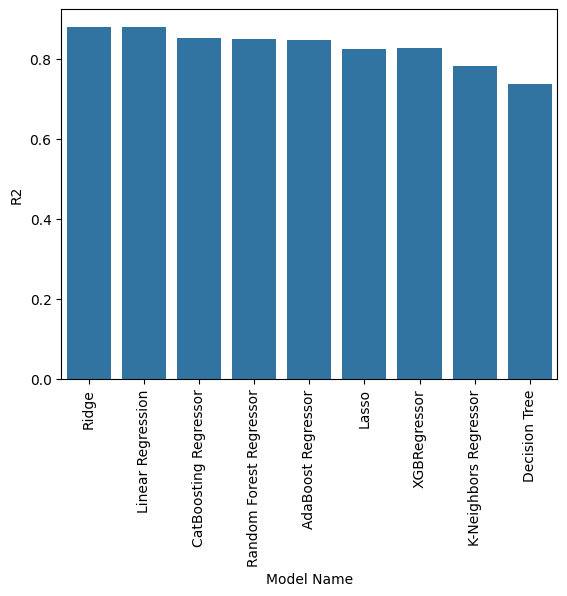

In [22]:
sns.barplot(data=cv_df, x = 'Model Name', y = 'R2')
plt.xticks(rotation = 90)
plt.show()

In [24]:
cv_df.set_index('Model Name', inplace=True)


In [32]:
cv_df

,RMSE_train,MAE_train,R2_train,RMSE,MAE,R2
Model Name,,,,,,
Ridge,5.425997,4.359388,0.868607,5.390387,4.211101,0.880593
Linear Regression,5.433052,4.363545,0.868370,5.395987,4.215820,0.880345
CatBoosting Regressor,5.907719,4.773501,0.844169,6.008632,4.612532,0.851632
Random Forest Regressor,6.081875,4.893823,0.833077,6.016492,4.668854,0.851243
AdaBoost Regressor,6.277414,5.003307,0.818819,6.071797,4.741426,0.848496
Lasso,6.611284,5.224446,0.805300,6.519695,5.157882,0.825320
XGBRegressor,6.608197,5.306552,0.805269,6.473307,5.057731,0.827797
K-Neighbors Regressor,7.154952,5.690250,0.771319,7.253041,5.621000,0.783813
Decision Tree,8.204970,6.556250,0.697087,7.991558,6.395000,0.737547


<Axes: xlabel='Model Name'>

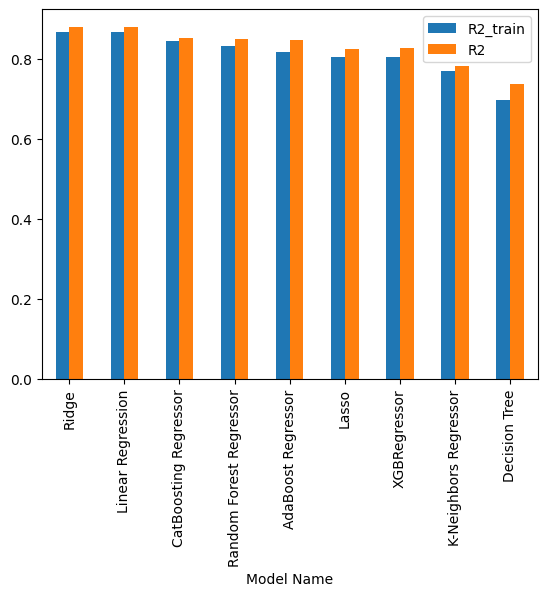

In [35]:
cv_df[['R2_train','R2']].plot(kind='bar')

<Axes: ylabel='Model Name'>

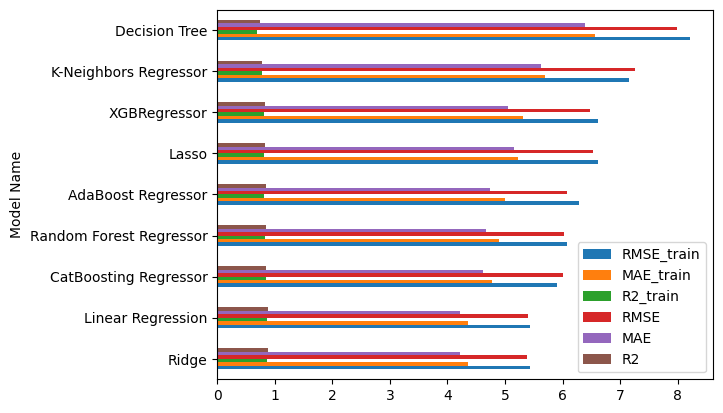

In [28]:
cv_df.plot(kind='barh')

In [ ]:
pd.DataFrame(list(zip(model_list, rmse_train_list, mae_train_list, r2_train_list,rmse_list, mae_list, r2_list)), columns=['Model Name', 'RMSE_train', 'MAE_train', 'R2_train','RMSE', 'MAE', 'R2']).sort_values(by=["R2_train"],ascending=False).reset_index(drop= True)

,Model Name,RMSE_train,MAE_train,R2_train,RMSE,MAE,R2
0,Decision Tree,0.279508,0.018750,0.999653,8.138796,6.490000,0.727786
1,XGBRegressor,1.007282,0.687467,0.995500,6.473307,5.057731,0.827797
2,Random Forest Regressor,2.296107,1.832683,0.976615,6.010880,4.713883,0.851521
3,CatBoosting Regressor,3.042664,2.405394,0.958936,6.008632,4.612532,0.851632
4,Ridge,5.323325,4.264988,0.874304,5.390387,4.211101,0.880593
5,Linear Regression,5.324331,4.267090,0.874257,5.395987,4.215820,0.880345
6,K-Neighbors Regressor,5.707683,4.516750,0.855498,7.253041,5.621000,0.783813
7,AdaBoost Regressor,5.718797,4.700106,0.854935,6.041509,4.660801,0.850004
8,Lasso,6.593816,5.206303,0.807146,6.519695,5.157882,0.825320


In [61]:
pd.DataFrame(list(zip(model_list, rmse_train_list, mae_train_list, r2_train_list,rmse_list, mae_list, r2_list)), columns=['Model Name', 'RMSE_train', 'MAE_train', 'R2_train','RMSE', 'MAE', 'R2']).sort_values(by=["R2"],ascending=False).reset_index(drop= True).to_csv('cross_validation.csv')

In [36]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]
mae_list = []
rmse_list = []
r2_train_list = []
mae_train_list = []
rmse_train_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))
    r2_train_list.append(model_train_r2)
    mae_train_list.append(model_train_mae)
    rmse_train_list.append(model_train_rmse)
    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    mae_list.append(model_test_mae)
    rmse_list.append(model_test_rmse)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 5.3243
- Mean Absolute Error: 4.2671
- R2 Score: 0.8743
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3960
- Mean Absolute Error: 4.2158
- R2 Score: 0.8803


Lasso
Model performance for Training set
- Root Mean Squared Error: 6.5938
- Mean Absolute Error: 5.2063
- R2 Score: 0.8071
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6.5197
- Mean Absolute Error: 5.1579
- R2 Score: 0.8253


Ridge
Model performance for Training set
- Root Mean Squared Error: 5.3233
- Mean Absolute Error: 4.2650
- R2 Score: 0.8743
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3904
- Mean Absolute Error: 4.2111
- R2 Score: 0.8806


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 5.7077
- Mean Absolute Error: 4.5167
- R2 Score: 0.8555
-----------------------

In [43]:
new_df = pd.DataFrame(list(zip(model_list, rmse_train_list, mae_train_list, r2_train_list,rmse_list, mae_list, r2_list)), columns=['Model Name', 'RMSE_train', 'MAE_train', 'R2_train','RMSE', 'MAE', 'R2']).sort_values(by=["R2_train"],ascending=False).reset_index(drop= True)

In [47]:
new_df.set_index('Model Name',inplace=True)

In [48]:
new_df

,RMSE_train,MAE_train,R2_train,RMSE,MAE,R2
Model Name,,,,,,
Decision Tree,0.279508,0.018750,0.999653,7.689928,6.145000,0.756985
XGBRegressor,1.007282,0.687467,0.995500,6.473307,5.057731,0.827797
Random Forest Regressor,2.272489,1.823073,0.977094,6.031919,4.726817,0.850480
CatBoosting Regressor,3.042664,2.405394,0.958936,6.008632,4.612532,0.851632
Ridge,5.323325,4.264988,0.874304,5.390387,4.211101,0.880593
Linear Regression,5.324331,4.267090,0.874257,5.395987,4.215820,0.880345
K-Neighbors Regressor,5.707683,4.516750,0.855498,7.253041,5.621000,0.783813
AdaBoost Regressor,5.841300,4.772044,0.848653,6.018583,4.746646,0.851140
Lasso,6.593816,5.206303,0.807146,6.519695,5.157882,0.825320


<Axes: xlabel='Model Name'>

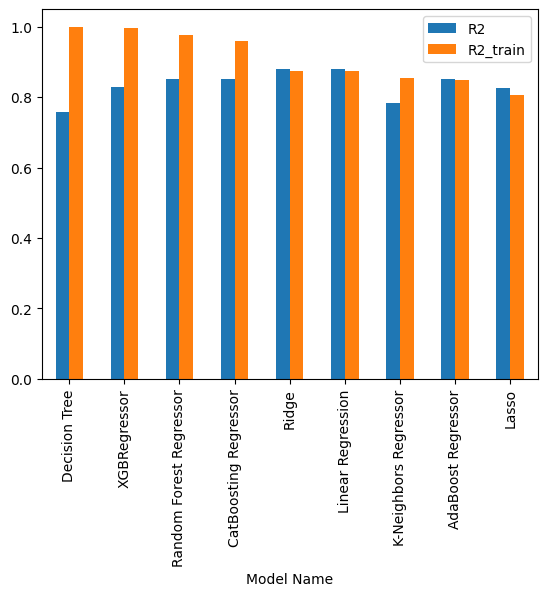

In [49]:
new_df[['R2','R2_train']].plot(kind = 'bar')

In [78]:
pd.DataFrame(list(zip(model_list, rmse_train_list, mae_train_list, r2_train_list,rmse_list, mae_list, r2_list)), columns=['Model Name', 'RMSE_train', 'MAE_train', 'R2_train','RMSE', 'MAE', 'R2']).sort_values(by=["R2_train"],ascending=False).reset_index(drop= True).to_csv('no_cross_validation.csv')

In [52]:
pd.DataFrame(list(zip(model_list, rmse_train_list, mae_train_list, r2_train_list,rmse_list, mae_list, r2_list)), columns=['Model Name', 'RMSE_train', 'MAE_train', 'R2_train','RMSE', 'MAE', 'R2']).sort_values(by=["R2"],ascending=False).reset_index(drop= True)

,Model Name,RMSE_train,MAE_train,R2_train,RMSE,MAE,R2
0,Ridge,5.323325,4.264988,0.874304,5.390387,4.211101,0.880593
1,Linear Regression,5.324331,4.267090,0.874257,5.395987,4.215820,0.880345
2,Random Forest Regressor,2.297898,1.826362,0.976578,5.985188,4.652263,0.852787
3,CatBoosting Regressor,3.042664,2.405394,0.958936,6.008632,4.612532,0.851632
4,AdaBoost Regressor,5.797303,4.736566,0.850924,6.045783,4.710741,0.849792
5,XGBRegressor,1.007282,0.687467,0.995500,6.473307,5.057731,0.827797
6,Lasso,6.593816,5.206303,0.807146,6.519695,5.157882,0.825320
7,K-Neighbors Regressor,5.707683,4.516750,0.855498,7.253041,5.621000,0.783813
8,Decision Tree,0.279508,0.018750,0.999653,7.870515,6.225000,0.745437


In [35]:
pd.DataFrame(list(zip(model_list, rmse_train_list, mae_train_list, r2_train_list)), columns=['Model Name', 'RMSE_train', 'MAE_train', 'R2_train']).sort_values(by=["R2_train"],ascending=False).reset_index(drop= True)

,Model Name,RMSE_train,MAE_train,R2_train
0,Decision Tree,0.279508,0.018750,0.999653
1,XGBRegressor,1.007282,0.687467,0.995500
2,Random Forest Regressor,2.292276,1.827737,0.976693
3,CatBoosting Regressor,3.042664,2.405394,0.958936
4,Ridge,5.323325,4.264988,0.874304
5,Linear Regression,5.324331,4.267090,0.874257
6,K-Neighbors Regressor,5.707683,4.516750,0.855498
7,AdaBoost Regressor,5.776453,4.686635,0.851995
8,Lasso,6.593816,5.206303,0.807146


In [34]:
pd.DataFrame(list(zip(model_list, rmse_train_list, mae_train_list, r2_train_list)), columns=['Model Name', 'RMSE_train', 'MAE_train', 'R2_train']).sort_values(by=["MAE_train"],ascending=True).reset_index(drop= True)

,Model Name,RMSE_train,MAE_train,R2_train
0,Decision Tree,0.279508,0.018750,0.999653
1,XGBRegressor,1.007282,0.687467,0.995500
2,Random Forest Regressor,2.292276,1.827737,0.976693
3,CatBoosting Regressor,3.042664,2.405394,0.958936
4,Ridge,5.323325,4.264988,0.874304
5,Linear Regression,5.324331,4.267090,0.874257
6,K-Neighbors Regressor,5.707683,4.516750,0.855498
7,AdaBoost Regressor,5.776453,4.686635,0.851995
8,Lasso,6.593816,5.206303,0.807146


In [ ]:
pd.DataFrame(list(zip(model_list, rmse_list, mae_list, r2_list)), columns=['Model Name', 'RMSE', 'MAE', 'R2']).sort_values(by=["RMSE"],ascending=True).reset_index(drop= True)

,Model Name,RMSE,MAE,R2
0,Ridge,5.390387,4.211101,0.880593
1,Linear Regression,5.395987,4.215820,0.880345
2,Random Forest Regressor,5.953382,4.624933,0.854348
3,CatBoosting Regressor,6.008632,4.612532,0.851632
4,AdaBoost Regressor,6.109052,4.754007,0.846631
5,XGBRegressor,6.473307,5.057731,0.827797
6,Lasso,6.519695,5.157882,0.825320
7,K-Neighbors Regressor,7.253041,5.621000,0.783813
8,Decision Tree,8.027764,6.345000,0.735163


In [21]:
pd.DataFrame(list(zip(model_list, rmse_list, mae_list, r2_list)), columns=['Model Name', 'RMSE', 'MAE', 'R2']).sort_values(by=["MAE"],ascending=True).reset_index(drop= True)

,Model Name,RMSE,MAE,R2
0,Ridge,5.390387,4.211101,0.880593
1,Linear Regression,5.395987,4.215820,0.880345
2,CatBoosting Regressor,6.008632,4.612532,0.851632
3,Random Forest Regressor,5.953382,4.624933,0.854348
4,AdaBoost Regressor,6.109052,4.754007,0.846631
5,XGBRegressor,6.473307,5.057731,0.827797
6,Lasso,6.519695,5.157882,0.825320
7,K-Neighbors Regressor,7.253041,5.621000,0.783813
8,Decision Tree,8.027764,6.345000,0.735163


In [23]:
pd.DataFrame(list(zip(model_list, rmse_list, mae_list, r2_list)), columns=['Model Name', 'RMSE', 'MAE', 'R2']).sort_values(by=["R2"],ascending=False).reset_index(drop= True)

,Model Name,RMSE,MAE,R2
0,Ridge,5.390387,4.211101,0.880593
1,Linear Regression,5.395987,4.215820,0.880345
2,Random Forest Regressor,5.953382,4.624933,0.854348
3,CatBoosting Regressor,6.008632,4.612532,0.851632
4,AdaBoost Regressor,6.109052,4.754007,0.846631
5,XGBRegressor,6.473307,5.057731,0.827797
6,Lasso,6.519695,5.157882,0.825320
7,K-Neighbors Regressor,7.253041,5.621000,0.783813
8,Decision Tree,8.027764,6.345000,0.735163


In [68]:
pd.DataFrame(list(zip(model_list, mae_list)), columns=['Model Name', 'mae_list']).sort_values(by=["mae_list"],ascending=True)

,Model Name,mae_list
2,Ridge,4.211101
0,Linear Regression,4.215820
7,CatBoosting Regressor,4.612532
5,Random Forest Regressor,4.629187
8,AdaBoost Regressor,4.722553
6,XGBRegressor,5.057731
1,Lasso,5.157882
3,K-Neighbors Regressor,5.621000
4,Decision Tree,6.405000


In [62]:
# Ensure r2_train_list is defined and contains training R² scores
eval_df = pd.DataFrame(
    list(zip(model_list, r2_list, r2_train_list)),  # Corrected zip usage
    columns=['Model Name', 'R2_Score', 'R2_training_score']  # Corrected column name
).sort_values(by=["R2_Score"], ascending=False)


In [63]:
eval_df['variance'] = eval_df['R2_Score'] - eval_df['R2_training_score']

In [64]:
eval_df.sort_values(by=["R2_Score"], ascending=False)

,Model Name,R2_Score,R2_training_score,variance
2,Ridge,0.880593,0.868607,0.011986
0,Linear Regression,0.880345,0.868370,0.011975
5,Random Forest Regressor,0.853563,0.834531,0.019032
7,CatBoosting Regressor,0.851632,0.844169,0.007462
8,AdaBoost Regressor,0.848539,0.819846,0.028693
6,XGBRegressor,0.827797,0.805269,0.022527
1,Lasso,0.825320,0.805300,0.020019
3,K-Neighbors Regressor,0.783813,0.771319,0.012494
4,Decision Tree,0.744101,0.699231,0.044870


In [75]:
models = {
    "Linear Regression": LinearRegression(),  # No hyperparameters for LinearRegression as it has no regularization
    "Lasso": Lasso(alpha=0.8, max_iter=1000),  # alpha is the regularization strength
    "Ridge": Ridge(alpha=5.0),  # alpha is the regularization strength
    "K-Neighbors Regressor": KNeighborsRegressor(n_neighbors=5, weights='uniform', metric='minkowski'),  # n_neighbors is the number of neighbors
    "Decision Tree": DecisionTreeRegressor(max_depth=10, min_samples_split=10, min_samples_leaf=5),  # Depth, split, and leaf control model complexity
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=42),  # Number of trees and depth
    "XGBRegressor": XGBRegressor(learning_rate=0.1, n_estimators=100, max_depth=5, subsample=0.8, colsample_bytree=0.8),  # Learning rate and regularization parameters
    "CatBoosting Regressor": CatBoostRegressor(learning_rate=0.1, depth=6, l2_leaf_reg=3, iterations=100, verbose=False),  # Regularization and depth
    "AdaBoost Regressor": AdaBoostRegressor(n_estimators=50, learning_rate=0.1)  # Number of estimators and learning rate
}
model_list = []
r2_list =[]
mae_list = []
rmse_list = []
r2_train_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))
    r2_train_list.append(model_train_r2)
    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    mae_list.append(model_test_mae)
    rmse_list.append(model_test_rmse)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 5.3243
- Mean Absolute Error: 4.2671
- R2 Score: 0.8743
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3960
- Mean Absolute Error: 4.2158
- R2 Score: 0.8803


Lasso
Model performance for Training set
- Root Mean Squared Error: 6.3218
- Mean Absolute Error: 4.9933
- R2 Score: 0.8227
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6.2268
- Mean Absolute Error: 4.9258
- R2 Score: 0.8407


Ridge
Model performance for Training set
- Root Mean Squared Error: 5.3286
- Mean Absolute Error: 4.2640
- R2 Score: 0.8741
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3838
- Mean Absolute Error: 4.2022
- R2 Score: 0.8809


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 5.7077
- Mean Absolute Error: 4.5167
- R2 Score: 0.8555
-----------------------

### Results

In [76]:
# Ensure r2_train_list is defined and contains training R² scores
eval_df_params = pd.DataFrame(
    list(zip(model_list, r2_list, r2_train_list)),  # Corrected zip usage
    columns=['Model Name', 'R2_Score', 'R2_training_score']  # Corrected column name
).sort_values(by=["R2_Score"], ascending=False)


In [65]:
eval_df

,Model Name,R2_Score,R2_training_score,variance
2,Ridge,0.880593,0.868607,0.011986
0,Linear Regression,0.880345,0.868370,0.011975
5,Random Forest Regressor,0.853563,0.834531,0.019032
7,CatBoosting Regressor,0.851632,0.844169,0.007462
8,AdaBoost Regressor,0.848539,0.819846,0.028693
6,XGBRegressor,0.827797,0.805269,0.022527
1,Lasso,0.825320,0.805300,0.020019
3,K-Neighbors Regressor,0.783813,0.771319,0.012494
4,Decision Tree,0.744101,0.699231,0.044870


In [ ]:
eval_df['variance'] =eval_df_params['R2_Score'] - eval_df_params['R2_training_score']
eval_df_params

,Model Name,R2_Score,R2_training_score,variance
2,Ridge,0.880593,0.868607,0.011986
0,Linear Regression,0.880345,0.868370,0.011975
5,Random Forest Regressor,0.853563,0.834531,0.019032
7,CatBoosting Regressor,0.851632,0.844169,0.007462
8,AdaBoost Regressor,0.848539,0.819846,0.028693
6,XGBRegressor,0.827797,0.805269,0.022527
1,Lasso,0.825320,0.805300,0.020019
3,K-Neighbors Regressor,0.783813,0.771319,0.012494
4,Decision Tree,0.744101,0.699231,0.044870


## Linear Regression

In [71]:
lin_model = Ridge(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 88.06


## Plot y_pred and y_test

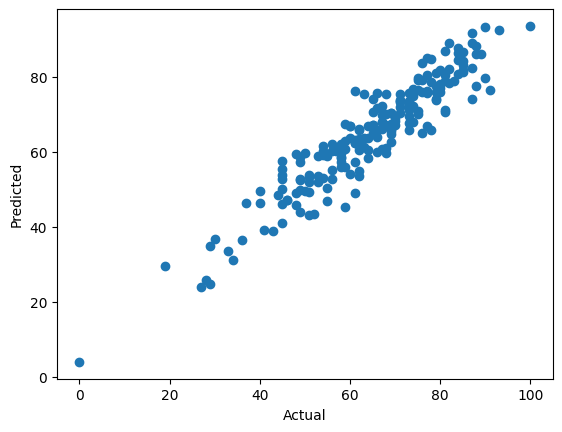

In [72]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

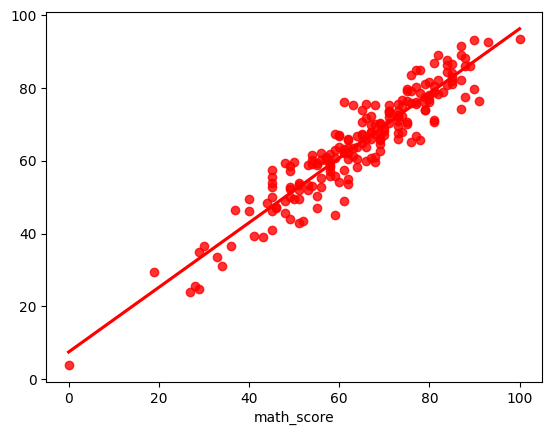

In [73]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

#### Difference between Actual and Predicted Values

In [74]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
521,91,76.398705,14.601295
737,53,58.842469,-5.842469
740,80,76.992129,3.007871
660,74,76.805898,-2.805898
411,84,87.615387,-3.615387
...,...,...,...
408,52,43.492293,8.507707
332,62,62.170763,-0.170763
208,74,67.910325,6.089675
613,65,67.061504,-2.061504
